In [1]:
#import all the dependencies
import numpy as np
import pandas as pd
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

In [2]:
#upload the data from our database
x = pd.read_csv('https://gentrificationmldata.s3.amazonaws.com/california_blank_tagged.csv')
df = pd.DataFrame(x)
df.set_index('zip', inplace=True)

In [3]:
#set the features only to the percent change
X = df[['percent_change_house', 'percent_change_income', 'percent_change_rent', 'index_change',
      'percent_change_public_tranp', 'percent_change_population', 'percent_change_white']]


y = df['Outcome']

In [4]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, stratify=y, test_size=0.3)


In [5]:
#scale the data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_scaler = scaler.fit(X_train)


X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [403]:
#get the calss count
print('y_resampled class distribution')
print(y_resampled.value_counts(normalize=True))
print('y_test class distribution')
print(y_test.value_counts(normalize=True))


y_resampled class distribution
1    0.5
0    0.5
Name: Outcome, dtype: float64
y_test class distribution
0    0.899083
1    0.100917
Name: Outcome, dtype: float64


In [404]:
#selecting the best hyperparameters for random forest with grid search
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 1)

clf = RandomForestClassifier(random_state = 1) 
scoring = {'Recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
          }

params = {
    'min_samples_split': [3, 5, 7], 
    'n_estimators' : [100, 120, 200],
    'max_depth': [2, 3, 4, 5],
    'max_features': [2, 4, 6, 8]
}


grid_clf = GridSearchCV(estimator = clf, param_grid = params, cv = cv, n_jobs=-1, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   23.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                             

In [405]:
#get the best estimators
print(grid_clf.best_estimator_)
print(grid_clf.best_params_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
{'max_depth': 2, 'max_features': 2, 'min_samples_split': 3, 'n_estimators': 100}


In [6]:
#reasample the minority class
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(random_state=1)
X_resampled, y_resampled = sampler.fit_resample(X_train_scaled,y_train)

Counter(y_resampled)

Using TensorFlow backend.


Counter({0: 686, 1: 686})

In [7]:
#ta da, the classifier itself
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='sqrt',
                       max_leaf_nodes=2, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

In [8]:
#fit the model and predict the outcome
clf = clf.fit(X_resampled, y_resampled)
pred = clf.predict(X_test_scaled)

In [9]:
#create a confusion matrix
cm = confusion_matrix(y_test, pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df
acc = accuracy_score(y_test, pred)

In [10]:
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc}")
print("Classification Report")
print(classification_report(y_test, pred))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,211,83
Actual 1,19,14


Accuracy Score : 0.6880733944954128
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.72      0.81       294
           1       0.14      0.42      0.22        33

    accuracy                           0.69       327
   macro avg       0.53      0.57      0.51       327
weighted avg       0.84      0.69      0.75       327



In [11]:
#get the ROC score
y_score = clf.predict_proba(X_test_scaled)[:,1]

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)
print('roc_auc_score for Random Forest: ', roc_auc_score(y_test, y_score))

roc_auc_score for Random Forest:  0.5616883116883117


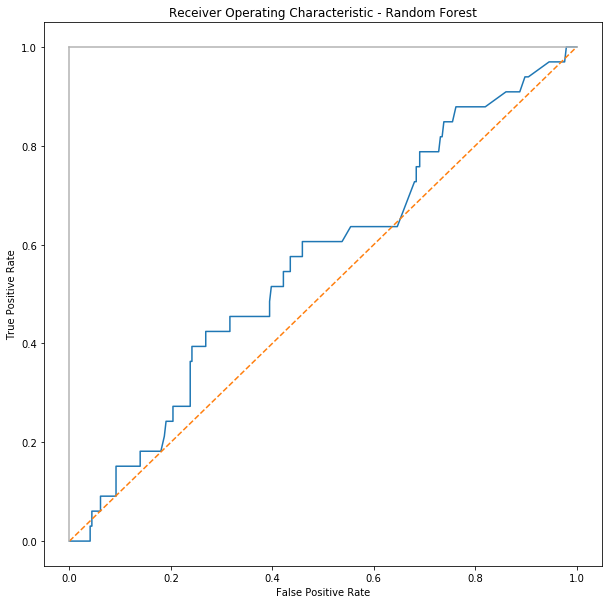

In [13]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [415]:
# ytrain = y_train.values
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(ytrain),
#                                                  ytrain)

In [22]:
#create a dataframe with predicted outcome that we will plot in our dashboard 
x_df = pd.DataFrame(X_test)
x_df['outcome'] = pred
x_df.to_csv('predicted.csv')

In [23]:
#send the predcited csv to the database 
from config import *
import boto3
s3 = boto3.client('s3',
         aws_access_key_id=accesskeyid,
         aws_secret_access_key= secretkey)
with open("predicted.csv", "rb") as f:
    s3.upload_fileobj(f, "gentrificationoutcome", "predicted.csv")